In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pyproj
from scipy.interpolate import griddata
import xarray as xr

In [3]:
mycmap = copy.copy(plt.get_cmap('plasma_r'))
mycmap.set_bad('darkgreen')

In [4]:
da = xr.open_dataset('SOG_500m.nc')

In [5]:
da

<xarray.Dataset>
Dimensions:                    (albers_conical_equal_area: 0, x: 255, y: 367)
Coordinates:
  * x                          (x) float64 9.862e+05 9.874e+05 ... 1.291e+06
  * y                          (y) float64 6.659e+05 6.647e+05 ... 2.267e+05
  * albers_conical_equal_area  (albers_conical_equal_area) int32 
Data variables:
    SOG_500m                   (y, x) float64 ...
Attributes:
    Conventions:      CF-1.0
    Source_Software:  Esri ArcGIS

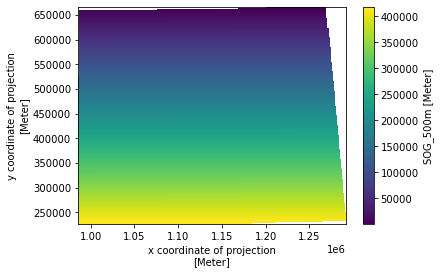

In [6]:
da.SOG_500m.plot();

In [7]:
np.__version__

'1.18.5'

In [8]:
pyproj.__version__

'2.6.1.post1'

In [9]:
transformer = pyproj.Transformer.from_crs("epsg:3005", 'epsg:4326')

In [10]:
xx, yy = np.meshgrid(da.x, da.y)

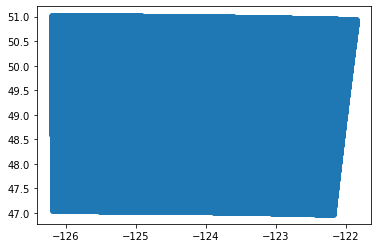

In [11]:
gislats, gislons = transformer.transform(xx=xx, yy=yy)
plt.scatter(gislons, gislats);

In [12]:
bathy = xr.open_dataset('~/Documents/MEOPAR/grid/bathymetry_201702.nc')
mesh = xr.open_dataset('/Users/sallen/Documents/MEOPAR/grid/mesh_mask201702.nc')
mesozoo = np.load('Hindcast_201905/SalishSea_sep_feb_climate_2007_2019_mesozoo_0_51m', allow_pickle=True)
microzoo = np.load('Hindcast_201905/SalishSea_sep_feb_climate_2007_2019_microzoo_0_51m', allow_pickle=True)
mesozoo = mesozoo.filled(fill_value=np.nan)
microzoo = microzoo.filled(fill_value=np.nan);

In [13]:
maxlon, maxlat, minlon, minlat = bathy.nav_lon.max(), bathy.nav_lat.max(), bathy.nav_lon.min(), bathy.nav_lat.min()
print ((maxlon+minlon)/2., (maxlat+minlat)/2.)

<xarray.DataArray 'nav_lon' ()>
array(-123.85932159) <xarray.DataArray 'nav_lat' ()>
array(48.98223305)


In [14]:
points = (np.array((np.array(bathy.nav_lon).flatten(), np.array(bathy.nav_lat).flatten()))).transpose()
points.shape

(357404, 2)

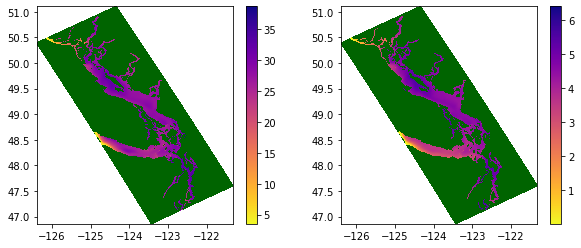

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
colours = axs[0].pcolormesh(bathy.nav_lon, bathy.nav_lat, mesozoo, cmap=mycmap, shading='nearest')
fig.colorbar(colours, ax=axs[0])
colours = axs[1].pcolormesh(bathy.nav_lon, bathy.nav_lat, microzoo, cmap=mycmap, shading='nearest')
fig.colorbar(colours, ax=axs[1])
for ax in axs:
    ax.set_aspect(1./np.sin(np.pi*49/180));

In [16]:
gis_meso = griddata(points, mesozoo.flatten(), (gislons, gislats), method='linear')
gis_micro = griddata(points, microzoo.flatten(), (gislons, gislats), method='linear')

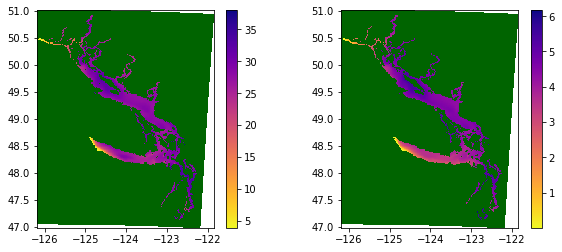

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
colours = axs[0].pcolormesh(gislons, gislats, gis_meso, cmap=mycmap, shading='nearest')
fig.colorbar(colours, ax=axs[0])
colours = axs[1].pcolormesh(gislons, gislats, gis_micro, cmap=mycmap, shading='nearest')
fig.colorbar(colours, ax=axs[1])
for ax in axs:
    ax.set_aspect(1./np.sin(np.pi*49/180));


In [18]:
444/367

1.2098092643051772

In [19]:
314/255

1.231372549019608

In [20]:
meso_attrs = {'standard_name': 'mole_concentration_of_mesozooplankton_expressed_as_nitrogen_in_sea_water',
 'long_name': 'Mesozooplankton Concentration',
 'units': 'mmol m-2',
 'vertical_average': '0-51~m',
 'temporal_average': 'September to February',
 'climate_average': '2007-2019',
  'source': 'SalishSeaCast',
             'website': 'salishsea.eos.ubc.ca/nemo/',
             'version': '201905'}
micro_attrs = copy.copy(meso_attrs)
micro_attrs['standard_name'] = 'mole_concentration_of_microzooplankton_expressed_as_nitrogen_in_sea_water'
micro_attrs['long_name'] = 'Microzooplankton Concentration'

In [21]:
meso_da = xr.DataArray(gis_meso, coords=[da.y, da.x], dims=['y', 'x'], attrs=meso_attrs)
micro_da = xr.DataArray(gis_micro, coords=[da.y, da.x], dims=['y', 'x'], attrs=micro_attrs)

In [22]:
da['Mesozooplankton'] = meso_da
da['Microzooplankton'] = micro_da

In [23]:
da

<xarray.Dataset>
Dimensions:                    (albers_conical_equal_area: 0, x: 255, y: 367)
Coordinates:
  * x                          (x) float64 9.862e+05 9.874e+05 ... 1.291e+06
  * y                          (y) float64 6.659e+05 6.647e+05 ... 2.267e+05
  * albers_conical_equal_area  (albers_conical_equal_area) int32 
Data variables:
    SOG_500m                   (y, x) float64 nan nan nan nan ... nan nan nan
    Mesozooplankton            (y, x) float64 nan nan nan nan ... nan nan nan
    Microzooplankton           (y, x) float64 nan nan nan nan ... nan nan nan
Attributes:
    Conventions:      CF-1.0
    Source_Software:  Esri ArcGIS

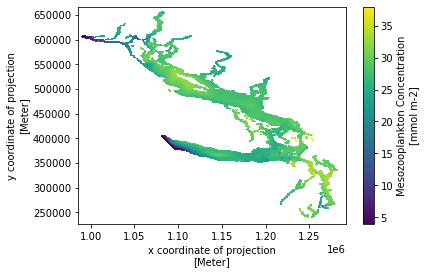

In [24]:
da.Mesozooplankton.plot();

In [25]:
da.Microzooplankton.attrs

{'standard_name': 'mole_concentration_of_microzooplankton_expressed_as_nitrogen_in_sea_water',
 'long_name': 'Microzooplankton Concentration',
 'units': 'mmol m-2',
 'vertical_average': '0-51~m',
 'temporal_average': 'September to February',
 'climate_average': '2007-2019',
 'source': 'SalishSeaCast',
 'website': 'salishsea.eos.ubc.ca/nemo/',
 'version': '201905'}

In [26]:
da.to_netcdf('SalishSea_sep_feb_climate_2007_2019_zoo_0_51m.nc')

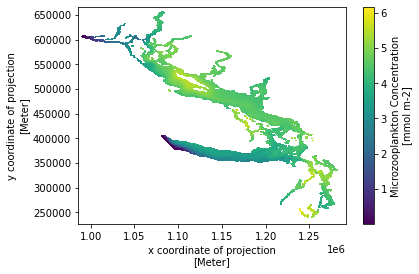

In [27]:
da.Microzooplankton.plot();